# Retail forecasting

In [1]:
!cat ../docs/tasks.txt

Задание такое:

Задача на прогнозирование временных рядов для двух товаров. Два уровня сложности:
Легкий – прогнозирование целиком по региону
Сложный – прогнозирование по каждому магазину
Есть критерии успешности: граница для WAPE – указана в файлах

Задача на кластеризацию. Задача больше творческая, надо сделать и объяснить ее результаты.
 

Время на выполнение обеих задач, должно быть не более 3х часов. Засеките время выполнения.

 

Использовать можно свой любимый инструмент (R, Python, C++, …)

 

Результаты надо защитить в виде подготовленной презентации


In [2]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from datetime import datetime, date, timedelta
import dateutil
import itertools

import math
from scipy.stats import pearsonr
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Lasso, Ridge

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict, RandomizedSearchCV, StratifiedShuffleSplit, KFold
from sklearn.feature_selection import SelectFromModel

import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [3]:
RANDOM_STATE = 7
N_FOLDS = 3

## Forecasting

Задача спрогнозировать спрос на 28 дней в следующих разрезах:
     1. Регион (т.е. все магазины) / товар / день
     2. Магазин / товар / день

Исторические данные: лист Train_data
Метрика качества: WAPE
На тестовой выборке (лист Test_data и лист Test_demand) получить качество:
     1. В разрезе регион / товар / день лучше 30%
     2. В разрезе магазин / товар / день лучше 50%

Желательно применить несколько различных техник прогнозирования и анализа данных (ARIMA, случайный лес, ...)

In [4]:
def get_wape(y_test, y_pred):
    # Function calculate WAPE metric
    return sum([abs(y_test[i] - y_pred[i]) for i in range(len(y_test))])/sum(y_test)

In [5]:
train_df = pd.read_excel('../data/FC_Data.xlsx',sheet_name='Train_data')
print(f'Shape of dataset: {train_df.shape}')
train_df.head()

Shape of dataset: (86916, 7)


,Store_id,SKU_id,Date,Promo,Demand,Regular_Price,Promo_Price
0,1,1,2015-01-01,NaN,22,163.78,NaN
1,1,1,2015-01-02,NaN,41,163.78,NaN
2,1,1,2015-01-03,NaN,35,163.78,NaN
3,1,1,2015-01-04,NaN,72,163.78,NaN
4,1,1,2015-01-05,NaN,25,163.78,NaN


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86916 entries, 0 to 86915
Data columns (total 7 columns):
Store_id         86916 non-null int64
SKU_id           86916 non-null int64
Date             86916 non-null datetime64[ns]
Promo            15349 non-null float64
Demand           86916 non-null int64
Regular_Price    86916 non-null float64
Promo_Price      15349 non-null float64
dtypes: datetime64[ns](1), float64(3), int64(3)
memory usage: 4.6 MB


In [7]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Store_id,86916.0,44.034735,25.913644,1.00,22.00,43.0,65.00,106.00
SKU_id,86916.0,1.496836,0.499993,1.00,1.00,1.0,2.00,2.00
Promo,15349.0,1.000000,0.000000,1.00,1.00,1.0,1.00,1.00
Demand,86916.0,193.088695,366.859645,0.00,3.00,72.0,226.00,9686.00
Regular_Price,86916.0,139.212821,9.180827,121.64,131.70,138.5,142.57,176.82
Promo_Price,15349.0,120.078875,9.961642,100.30,116.61,119.6,127.49,143.80


In [8]:
train_df.tail()

,Store_id,SKU_id,Date,Promo,Demand,Regular_Price,Promo_Price
86911,106,2,2016-05-18,NaN,9,138.5,NaN
86912,106,2,2016-05-19,NaN,3,138.5,NaN
86913,106,2,2016-05-20,NaN,13,138.5,NaN
86914,106,2,2016-05-21,NaN,3,138.5,NaN
86915,106,2,2016-05-22,NaN,0,138.5,NaN


In [9]:
test_df = pd.read_excel('../data/FC_Data.xlsx',sheet_name='Test_data')
print(f'Shape of test dataset: {test_df.shape}')
test_df.head()

Shape of test dataset: (5970, 7)


,Store_id,SKU_id,Date,Promo,Demand,Regular_Price,Promo_Price
0,1,1,2016-05-23,1.0,NaN,128.98,119.6
1,1,1,2016-05-24,NaN,NaN,128.98,NaN
2,1,1,2016-05-25,NaN,NaN,131.70,NaN
3,1,1,2016-05-26,NaN,NaN,131.70,NaN
4,1,1,2016-05-27,NaN,NaN,131.70,NaN


In [10]:
test_df_demand = pd.read_excel('../data/FC_Data.xlsx',sheet_name='Test_demand')
print(f'Shape of test dataset: {test_df_demand.shape}')
test_df_demand.head()

Shape of test dataset: (5970, 4)


,Store_id,SKU_id,Date,Demand
0,1,1,2016-05-23,242
1,1,1,2016-05-24,57
2,1,1,2016-05-25,63
3,1,1,2016-05-26,69
4,1,1,2016-05-27,44


In [11]:
# Create merged TEST dataframe with Demand
test_df = test_df.drop('Demand', axis=1).merge(test_df_demand, left_on=["Store_id","SKU_id","Date"], right_on=["Store_id","SKU_id","Date"])
test_df.head()

,Store_id,SKU_id,Date,Promo,Regular_Price,Promo_Price,Demand
0,1,1,2016-05-23,1.0,128.98,119.6,242
1,1,1,2016-05-24,NaN,128.98,NaN,57
2,1,1,2016-05-25,NaN,131.70,NaN,63
3,1,1,2016-05-26,NaN,131.70,NaN,69
4,1,1,2016-05-27,NaN,131.70,NaN,44


In [12]:
print(f"Дата начала периода прогноза: {test_df['Date'].min()}")
print(f"Дата окончания периода прогноза: {test_df['Date'].max()}")
print(f"Количество дней прогноза: {(test_df['Date'].max()-test_df['Date'].min()).days + 1}")

Дата начала периода прогноза: 2016-05-23 00:00:00
Дата окончания периода прогноза: 2016-06-19 00:00:00
Количество дней прогноза: 28


In [13]:
# Create new features
# Weekday from Date
train_df['WEEKDAY'] = train_df['Date'].apply(lambda x: int(x.strftime('%w')))
# Cos of day number in year
train_df['YEARDAY'] = train_df['Date'].apply(lambda x: math.cos(int(x.strftime('%j'))*2*math.pi/366))
# PRICE == Promo_Price if Promo_Price is not null else Regular_Price
train_df['PRICE'] = train_df.apply(lambda x: x['Promo_Price'] if not np.isnan(x['Promo_Price']) else x['Regular_Price'], axis=1)

In [14]:
# Check it when Promo
train_df[train_df['Promo']==1].head()

,Store_id,SKU_id,Date,Promo,Demand,Regular_Price,Promo_Price,WEEKDAY,YEARDAY,PRICE
47,1,1,2015-02-17,1.0,371,149.37,143.80,2,0.679273,143.80
48,1,1,2015-02-18,1.0,509,149.37,135.64,3,0.666575,135.64
49,1,1,2015-02-19,1.0,851,149.37,135.64,4,0.653680,135.64
50,1,1,2015-02-20,1.0,914,149.37,135.64,5,0.640593,135.64
51,1,1,2015-02-21,1.0,606,149.37,135.64,6,0.627317,135.64


In [15]:
# Fill NA and drop unused columns
train_df = train_df.fillna(0,axis=1).drop(['Regular_Price','Promo_Price'],axis=1)
print(train_df.shape)

(86916, 8)


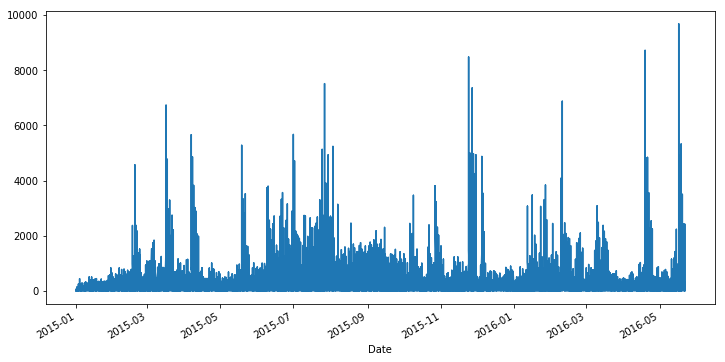

In [16]:
# Total view on series of demand
pd.Series(train_df['Demand'].values, index=train_df['Date']).plot(figsize=(12,6));

In [17]:
train_df.tail()

,Store_id,SKU_id,Date,Promo,Demand,WEEKDAY,YEARDAY,PRICE
86911,106,2,2016-05-18,0.0,9,3,-0.728028,138.5
86912,106,2,2016-05-19,0.0,3,4,-0.739689,138.5
86913,106,2,2016-05-20,0.0,13,5,-0.751132,138.5
86914,106,2,2016-05-21,0.0,3,6,-0.762354,138.5
86915,106,2,2016-05-22,0.0,0,0,-0.773351,138.5


ARIMA можно использовать, если нет пропусков/нулей в данных. Проверим это.

In [18]:
print(f"Пропусков в датах в целом нет? {len(pd.unique(train_df[train_df['Demand']>0]['Date'])) == ((train_df[train_df['Demand']>0]['Date'].max()-train_df[train_df['Demand']>0]['Date'].min()).days + 1)}")

Пропусков в датах в целом нет? True


In [19]:
print(f"Пропусков в датах для SKU_id=1 нет? {len(pd.unique(train_df[(train_df['Demand']>0) & (train_df['SKU_id']==1)]['Date'])) == \
                                             ((train_df[(train_df['Demand']>0) & (train_df['SKU_id']==1)]['Date'].max()-train_df[(train_df['Demand']>0) & (train_df['SKU_id']==1)]['Date'].min()).days + 1)}")

Пропусков в датах для SKU_id=1 нет? True


In [20]:
print(f"Пропусков в датах для SKU_id=2 нет? {len(pd.unique(train_df[(train_df['Demand']>0) & (train_df['SKU_id']==2)]['Date'])) == \
                                             ((train_df[(train_df['Demand']>0) & (train_df['SKU_id']==2)]['Date'].max()-train_df[(train_df['Demand']>0) & (train_df['SKU_id']==2)]['Date'].min()).days + 1)}")

Пропусков в датах для SKU_id=2 нет? True


In [21]:
print(train_df.shape[0])
print(f"Для каждой даты есть записи по каждому магазину и каждому товару? {len(pd.unique(train_df['Date']))*len(pd.unique(train_df['SKU_id']))*len(pd.unique(train_df['Store_id'])) == train_df.shape[0]}")

86916
Для каждой даты есть записи по каждому магазину и каждому товару? False


ARIMA поможет только в прогнозе на уровне итого по региону:

In [22]:
# Create grouped dataframe with summary Demand for all stores (whole Region) for each Date and SKU_id
grouped_train_df = train_df.groupby(['Date','SKU_id'])["Demand"].agg(sum).reset_index()
print(grouped_train_df.shape)
grouped_train_df.head()

(1016, 3)


,Date,SKU_id,Demand
0,2015-01-01,1,1180
1,2015-01-01,2,85
2,2015-01-02,1,3667
3,2015-01-02,2,244
4,2015-01-03,1,4987


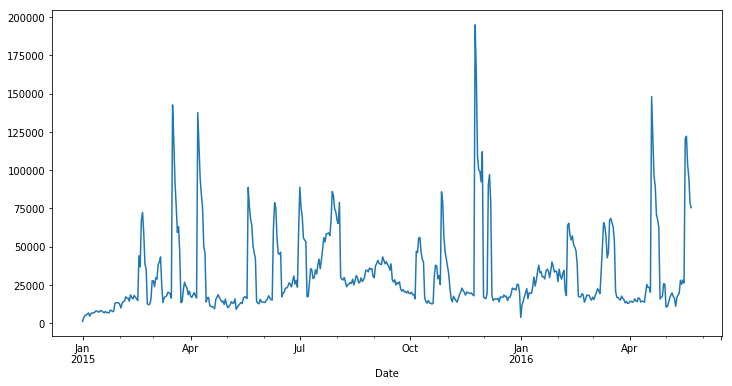

In [23]:
# Look at the SKU_id = 1 - there are many outliers
pd.Series(grouped_train_df[grouped_train_df['SKU_id']==1]['Demand'].values, index=grouped_train_df[grouped_train_df['SKU_id']==1]['Date']).plot(figsize=(12,6));

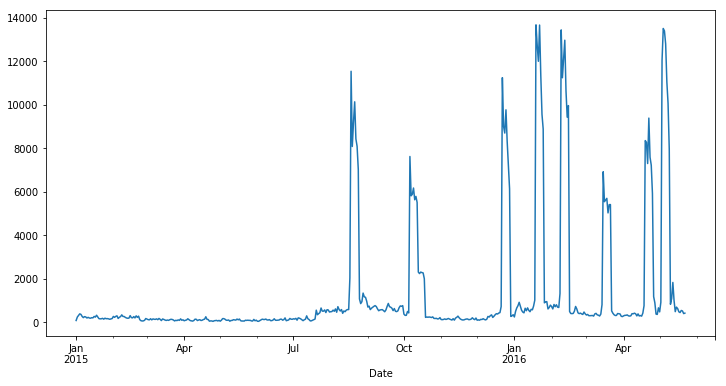

In [24]:
# Look at the SKU_id = 2 - there are many outliers
pd.Series(grouped_train_df[grouped_train_df['SKU_id']==2]['Demand'].values, index=grouped_train_df[grouped_train_df['SKU_id']==2]['Date']).plot(figsize=(12,6));

In [25]:
from statsmodels.tsa.arima_model import ARIMA
# Set Test dataframe to the same form as the Train dataframe
df_test = test_df.groupby(['Date','SKU_id'])["Demand"].agg(sum).reset_index()

In [26]:
def get_arima_model_prediction(data, P, D, Q):
    # Fit and predict for ARIMA model
    model = ARIMA(data, order=(P, D, Q))
    model_fit = model.fit(disp=0)
    fcst = model_fit.forecast()[0]
    return fcst

def get_arima_prediction(SKU_id, DF_train, DF_test):
    # Function fitted on DF_train and creates predictions on DF_test for input SKU_id
    X_train = DF_train[DF_train['SKU_id']==SKU_id]['Demand'].values
    X_test = DF_test[DF_test['SKU_id']==SKU_id]['Demand'].values

    data = [x for x in X_train]
    y_pred = list()

    for t in range(len(X_test)):
        x =  X_test[t]
        arima_pred = get_arima_model_prediction(data, 1,2,1)    
        y_pred.append(arima_pred)
        data.append(x)
    return y_pred

In [27]:
y_pred1 = get_arima_prediction(SKU_id = 1, DF_train = grouped_train_df, DF_test = df_test)
print(len(y_pred1))

28


In [28]:
get_wape(df_test[df_test['SKU_id']==1]['Demand'].values,[i[0] for i in y_pred1])

0.21654685019605296

In [29]:
y_pred2 = get_arima_prediction(SKU_id = 2, DF_train = grouped_train_df, DF_test = df_test)
print(len(y_pred2))

28


In [30]:
get_wape(df_test[df_test['SKU_id']==2]['Demand'].values,[i[0] for i in y_pred2])

0.29848084176233436

В итоге получили WAPE на каждом из товаров меньше 30%.

- Но это нечестный прогноз на 28 дней, т.к. каждый раз после расчета прогноза на следующую точку мы подставляем реальный факт для тренировки новой модели ARIMA и прогноза еще на день вперед.
- По-честному мы должны в факт для прогноза следующего дня добавлять посчитанный прогноз предыдущего дня.

In [31]:
def get_honest_arima_prediction(SKU_id, DF_train, DF_test):
    # Function fitted on DF_train and creates predictions on DF_test for input SKU_id
    X_train = DF_train[DF_train['SKU_id']==SKU_id]['Demand'].values
    X_test = DF_test[DF_test['SKU_id']==SKU_id]['Demand'].values

    data = [x for x in X_train]
    y_pred = list()

    for t in range(len(X_test)):
        arima_pred = get_arima_model_prediction(data, 1,2,1)    
        y_pred.append(arima_pred)
        data.append(arima_pred)
    return y_pred

In [32]:
y_pred1 = get_honest_arima_prediction(SKU_id = 1, DF_train = grouped_train_df, DF_test = df_test)
print(len(y_pred1))

28


In [33]:
get_wape(df_test[df_test['SKU_id']==1]['Demand'].values,[i[0] for i in y_pred1])

1.6047218576477646

In [34]:
y_pred2 = get_honest_arima_prediction(SKU_id = 2, DF_train = grouped_train_df, DF_test = df_test)
print(len(y_pred2))

28


In [35]:
get_wape(df_test[df_test['SKU_id']==2]['Demand'].values,[i[0] for i in y_pred2])

0.920613335182272

Вот это уже похоже на качество честного прогноза.

## Детальный прогноз по каждому магазину

Попробуем случайным лесом прогноз для каждого магазина

In [36]:
train_df.head()

,Store_id,SKU_id,Date,Promo,Demand,WEEKDAY,YEARDAY,PRICE
0,1,1,2015-01-01,0.0,22,4,0.999853,163.78
1,1,1,2015-01-02,0.0,41,5,0.999411,163.78
2,1,1,2015-01-03,0.0,35,6,0.998674,163.78
3,1,1,2015-01-04,0.0,72,0,0.997643,163.78
4,1,1,2015-01-05,0.0,25,1,0.996318,163.78


In [37]:
new_train_df = train_df.copy()
new_train_df['Date'] = new_train_df['Date'] + timedelta(days=1)
# Demand from previous day for it SKU_id and Store_id
train_df['Demand_lag1_day'] = train_df.merge(new_train_df, how='left', left_on=["Store_id","SKU_id","Date"], right_on=["Store_id","SKU_id","Date"]).fillna(0)['Demand_y']
new_train_df = train_df.copy()
new_train_df['Date'] = new_train_df['Date'] + timedelta(days=7)
# Demand from the same weekday last week for it SKU_id and Store_id
train_df['Demand_lag1_week'] = train_df.merge(new_train_df, how='left', left_on=["Store_id","SKU_id","Date"], right_on=["Store_id","SKU_id","Date"]).fillna(0)['Demand_y']
train_df.head(9)

,Store_id,SKU_id,Date,Promo,Demand,WEEKDAY,YEARDAY,PRICE,Demand_lag1_day,Demand_lag1_week
0,1,1,2015-01-01,0.0,22,4,0.999853,163.78,0.0,0.0
1,1,1,2015-01-02,0.0,41,5,0.999411,163.78,22.0,0.0
2,1,1,2015-01-03,0.0,35,6,0.998674,163.78,41.0,0.0
3,1,1,2015-01-04,0.0,72,0,0.997643,163.78,35.0,0.0
4,1,1,2015-01-05,0.0,25,1,0.996318,163.78,72.0,0.0
5,1,1,2015-01-06,0.0,38,2,0.994700,163.78,25.0,0.0
6,1,1,2015-01-07,0.0,31,3,0.992788,163.78,38.0,0.0
7,1,1,2015-01-08,0.0,35,4,0.990584,163.78,31.0,22.0
8,1,1,2015-01-09,0.0,44,5,0.988088,163.78,35.0,41.0


In [38]:
# Create features in TEST dataframe as in TRAIN
test_df['WEEKDAY'] = test_df['Date'].apply(lambda x: int(x.strftime('%w')))
test_df['YEARDAY'] = test_df['Date'].apply(lambda x: math.cos(int(x.strftime('%j'))*2*math.pi/366))
test_df['PRICE'] = test_df.apply(lambda x: x['Promo_Price'] if not np.isnan(x['Promo_Price']) else x['Regular_Price'], axis=1)
test_df = test_df.fillna(0,axis=1).drop(['Regular_Price','Promo_Price'],axis=1)
new_test_df = test_df.copy()
new_test_df['Date'] = new_test_df['Date'] + timedelta(days=1)
test_df['Demand_lag1_day'] = test_df.merge(new_test_df, how='left', left_on=["Store_id","SKU_id","Date"], right_on=["Store_id","SKU_id","Date"]).fillna(0)['Demand_y']
new_test_df = test_df.copy()
new_test_df['Date'] = new_test_df['Date'] + timedelta(days=7)
test_df['Demand_lag1_week'] = test_df.merge(new_test_df, how='left', left_on=["Store_id","SKU_id","Date"], right_on=["Store_id","SKU_id","Date"]).fillna(0)['Demand_y']
print(test_df.shape)

(5970, 10)


In [39]:
# Create train and test dataframes
X_train, y_train = train_df.drop(['Demand','Date'],axis=1), train_df['Demand'].values
X_test, y_test = test_df.drop(['Demand','Date'],axis=1), test_df['Demand'].values

In [40]:
X_test.head()

,Store_id,SKU_id,Promo,WEEKDAY,YEARDAY,PRICE,Demand_lag1_day,Demand_lag1_week
0,1,1,1.0,1,-0.784120,119.60,0.0,0.0
1,1,1,0.0,2,-0.794658,128.98,242.0,0.0
2,1,1,0.0,3,-0.804962,131.70,57.0,0.0
3,1,1,0.0,4,-0.815028,131.70,63.0,0.0
4,1,1,0.0,5,-0.824855,131.70,69.0,0.0


In [41]:
# Create model for RandomForest with basic parameters like depth, min_leafs and etc.
model_rf_def = RandomForestRegressor(n_estimators=100, max_depth=20, min_samples_leaf=20, max_features=0.8, n_jobs=-1, random_state=RANDOM_STATE)
# Fit this model
model_rf_def.fit(X_train, y_train)
# Create a prediction from fitted model of Random Forest
y_pred = model_rf_def.predict(X_test)

In [42]:
# Calc WAPE-metric for Store/Ware/Day
get_wape(y_test, y_pred)

0.3982867928973589

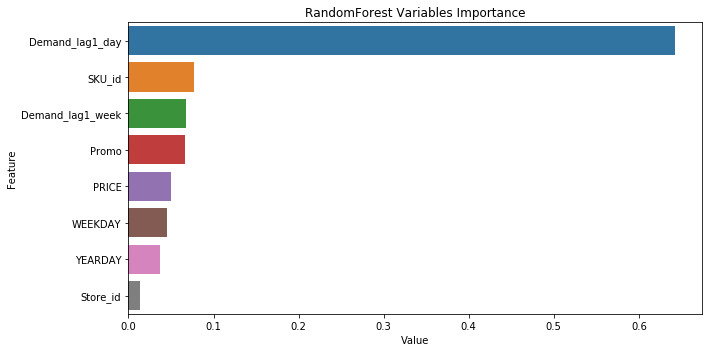

In [43]:
# Let's look at the features importance from the Random Forest model
feature_imp = pd.DataFrame(sorted(zip(model_rf_def.feature_importances_,X_train.columns)), columns=['Value','Feature'])
plt.figure(figsize=(10, 5))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('RandomForest Variables Importance')
plt.tight_layout()
plt.show()

## Clustering

Задача: выполнить кластеризацию магазинов, описать результаты кластеризации.
Данные:
      - На листе Sales_Data находятся данные продаж в разрезе категория/магазин/день
      - На листе Store_Data находятся характеристики магазинов

In [44]:
raw_df = pd.read_excel('../data/CL_Data.xlsx',sheet_name='Sales_Data')
print(f'Shape of dataset: {raw_df.shape}')
raw_df.head()

Shape of dataset: (670139, 10)


,Store,Date,Quantity_sold,Revenue,Num_of_soc_SKU,Num_of_promo_SKU,Lvl1,Lvl2,Lvl3,Num_of_SKU_in_lvl
0,1,2016-02-01,27,4240.21,1,13,ROOT,Алкольная продукция,Вина_1,190
1,1,2016-02-01,3,188.02,1,0,ROOT,Алкольная продукция,Вина_2,7
2,1,2016-02-01,0,0.00,1,2,ROOT,Алкольная продукция,Вина_3,22
3,1,2016-02-01,43,7700.36,1,2,ROOT,Алкольная продукция,Водка,80
4,1,2016-02-01,0,0.00,1,3,ROOT,Алкольная продукция,Коньяк,44


In [45]:
store_Data = pd.read_excel('../data/CL_Data.xlsx',sheet_name='Store_Data')
print(f'Shape of dataset: {store_Data.shape}')
store_Data.head()

Shape of dataset: (119, 11)


,Store,Status,Opening_Date,Square,Assortment_width,Latitude,Longitude,License,Alco_Forbid,Tobacco_Forbid,Competition_lvl
0,1,Opened,2015-07-03,1047.0,7773.0,62.089544,42.995538,X,NaN,NaN,NaN
1,2,Opened,2015-06-17,1005.0,8080.0,62.353845,43.187782,X,NaN,NaN,NaN
2,3,Opened,2007-05-31,932.0,7327.0,62.377145,43.134820,X,NaN,NaN,NaN
3,4,Opened,2015-06-22,789.0,6508.0,62.490032,42.988220,X,NaN,NaN,1.0
4,5,Opened,2015-06-01,1067.0,8147.0,62.491562,42.972590,X,NaN,NaN,1.0


In [46]:
# Fill empty values in Square with mean values
store_Data['Square'].fillna((store_Data['Square'].mean()), inplace=True)

In [47]:
# We have 11 different elements in Lvl2 of product hierarchy - let's use them as a features
len(pd.unique(raw_df['Lvl2']))

11

In [48]:
# Calc month feature
raw_df['Month'] = raw_df['Date'].apply(lambda x: x.month)
# Calculate summary for each month/store/lvl2 for "Quantity_sold","Revenue" and "Num_of_SKU_in_lvl" to calculate average monthly percent of sold_quantity per available "number of SKU in level" to see the sale-power of store
df_tmp = raw_df.groupby(['Month','Store','Lvl2'])["Quantity_sold","Revenue","Num_of_SKU_in_lvl"].agg(sum).reset_index()
# Calculate average monthly KPIs
df_tmp = df_tmp.groupby(['Store','Lvl2'])["Quantity_sold","Revenue","Num_of_SKU_in_lvl"].agg(np.mean).reset_index()
# Create dummies variable for LEVEL2 of product hierarchy
df = pd.concat([df_tmp[["Store","Quantity_sold","Revenue","Num_of_SKU_in_lvl"]],pd.get_dummies(df_tmp['Lvl2'])],axis=1)
# Create percent
df['Sold_in_lvl'] = df.apply(lambda x: x['Quantity_sold']/x['Num_of_SKU_in_lvl'], axis=1)
# Drop unused features
df.drop(['Quantity_sold','Num_of_SKU_in_lvl'], axis=1, inplace=True)
# Rename columns
df.columns = ['Store','Revenue','Alc','Bac','KidFood','Diabet','Cond','PetFood','Water','Add','Tab','Kid','Br','Sold_in_lvl']
# Fill dummies with percent = KPI of Sold_in_lvl
for c in ['Alc','Bac','KidFood','Diabet','Cond','PetFood','Water','Add','Tab','Kid','Br']:
    df[c] = df[c]*df['Sold_in_lvl']
df.drop('Sold_in_lvl', axis=1, inplace=True)
# Group dataframe to the single row for each store
df = df.groupby(['Store'])["Alc","Bac","KidFood","Diabet","Cond","PetFood","Water","Add","Tab","Kid","Br","Revenue"].agg(sum).reset_index()
# Merge dataframe to the attributes to get the square of stores
df = df.merge(store_Data[['Store','Square']], left_on=["Store"], right_on=["Store"])
print(df.shape)
df.head(10)

(103, 14)


,Store,Alc,Bac,KidFood,Diabet,Cond,PetFood,Water,Add,Tab,Kid,Br,Revenue,Square
0,1,0.300275,2.149165,1.230385,1.727069,1.949320,9.762331,1.385337,0.822255,2.220865,0.576590,8.037128,1.022814e+07,1047.0
1,2,0.545191,7.027134,2.620226,3.511610,4.151190,29.575847,2.453708,1.677054,2.521745,1.273234,13.103581,2.314427e+07,1005.0
2,3,0.371701,2.758914,1.234908,1.911515,2.180084,11.014311,1.825030,1.030597,2.720372,0.891680,6.346894,1.118703e+07,932.0
3,4,0.609614,3.694375,1.432687,2.460331,2.599241,13.640608,2.328957,1.254898,4.949867,0.851365,11.329470,1.302829e+07,789.0
4,5,0.763618,4.533633,2.211038,3.147070,3.318566,21.678563,2.489573,1.586891,4.475934,1.376133,11.670952,2.072401e+07,1067.0
5,6,0.438477,3.781000,1.910396,1.552950,3.034054,10.612109,1.882477,1.183244,7.385520,0.861969,10.060462,1.749460e+07,978.0
6,7,0.062485,3.105291,0.941750,1.599880,2.038333,9.930554,0.768731,0.731863,2.187756,0.857518,7.435266,9.179660e+06,808.0
7,8,0.537512,4.496704,2.452787,2.282903,4.074065,24.627598,3.345455,1.609117,7.043985,1.566216,14.498711,1.943161e+07,923.0
8,9,0.843565,4.795683,2.745313,3.254834,4.077256,20.990740,3.379456,1.484321,4.699756,1.023160,13.556331,2.295571e+07,1045.0
9,10,0.479896,4.433220,2.390544,2.934831,3.806510,18.819939,2.465456,1.359165,5.204966,1.273147,12.626050,2.047655e+07,1036.0


In [49]:
# Calculate new feature: average revenue per 1 square feet for each store
df['Revenue_per_square'] = df['Revenue']/df['Square']
# Drop unused features
df.drop(['Revenue','Square'], axis=1, inplace=True)
# Final dataframe
df.head()

,Store,Alc,Bac,KidFood,Diabet,Cond,PetFood,Water,Add,Tab,Kid,Br,Revenue_per_square
0,1,0.300275,2.149165,1.230385,1.727069,1.949320,9.762331,1.385337,0.822255,2.220865,0.576590,8.037128,9768.996297
1,2,0.545191,7.027134,2.620226,3.511610,4.151190,29.575847,2.453708,1.677054,2.521745,1.273234,13.103581,23029.120716
2,3,0.371701,2.758914,1.234908,1.911515,2.180084,11.014311,1.825030,1.030597,2.720372,0.891680,6.346894,12003.246645
3,4,0.609614,3.694375,1.432687,2.460331,2.599241,13.640608,2.328957,1.254898,4.949867,0.851365,11.329470,16512.405695
4,5,0.763618,4.533633,2.211038,3.147070,3.318566,21.678563,2.489573,1.586891,4.475934,1.376133,11.670952,19422.691949


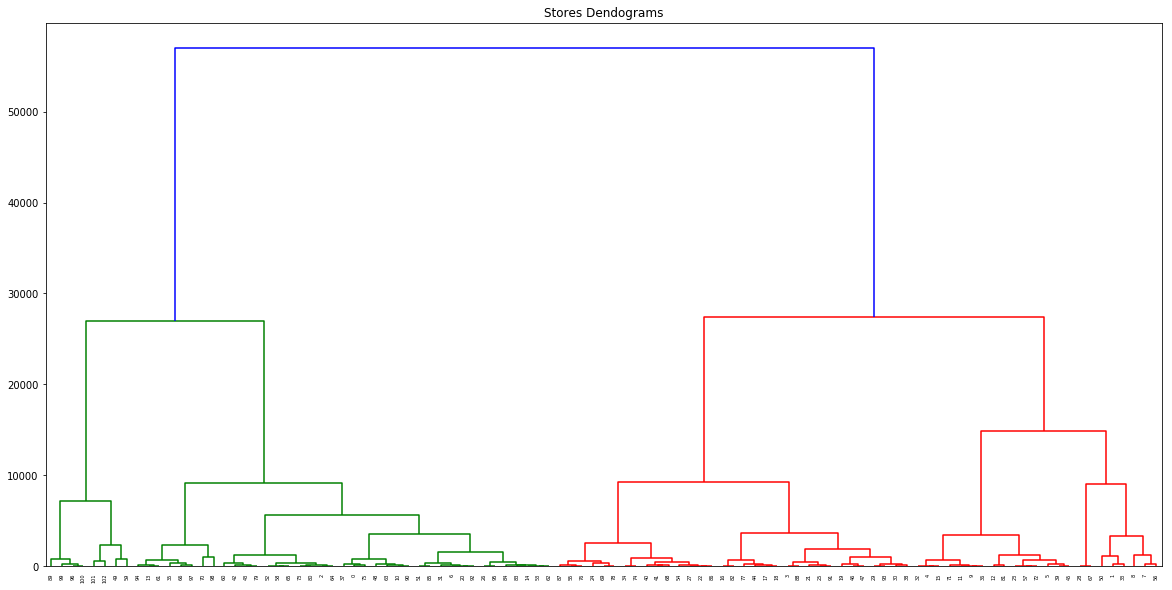

In [50]:
import scipy.cluster.hierarchy as shc
# Use only features for stores
data = df.iloc[:, 1:].values
plt.figure(figsize=(20, 10))
plt.title("Stores Dendograms")
# Calculate dendrogram clustering to see how stores divides per clusters
dend = shc.dendrogram(shc.linkage(data, method='ward'))

К примеру, можно разбить на 4 больших кластера:

In [51]:
from sklearn.cluster import AgglomerativeClustering
# From dendrogram we can see 4 big cluster and 9 smaller
# Let's split stores to 4 big clusters
cluster = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')
cluster.fit_predict(data)
#print(list(zip(df['Store'].values,cluster.labels_)))
pd.DataFrame(list(zip(df['Store'].values,cluster.labels_)),columns=['Store','Cluster']).head()

,Store,Cluster
0,1,1
1,2,0
2,3,1
3,4,2
4,5,0


In [52]:
# Join these clusters with their geo-coordinates to view on map
store_Data_gr = store_Data.merge(pd.DataFrame(list(zip(df['Store'].values,cluster.labels_)),columns=['Store','Cluster']).head(), left_on=["Store"], right_on=["Store"])[['Store','Latitude','Longitude','Cluster']]

In [53]:
import geopandas as gpd
from shapely.geometry import Point, Polygon

In [54]:
store_Data_grgeo = [Point(xy) for xy in zip(store_Data_gr.Longitude, store_Data_gr.Latitude)]
store_Data_gr['location'] = store_Data_grgeo
store_Data_gr.drop(['Latitude','Longitude'], axis = 1, inplace=True)
store_Data_gr = gpd.GeoDataFrame(store_Data_gr, geometry=store_Data_grgeo)

In [55]:
store_Data_gr.head()

,Store,Cluster,location,geometry
0,1,1,POINT (42.99553774486926 62.08954361204884),POINT (42.99553774486926 62.08954361204884)
1,2,0,POINT (43.18778217486925 62.35384548204885),POINT (43.18778217486925 62.35384548204885)
2,3,1,POINT (43.13482017486925 62.37714548204884),POINT (43.13482017486925 62.37714548204884)
3,4,2,POINT (42.98822017486925 62.49003248204884),POINT (42.98822017486925 62.49003248204884)
4,5,0,POINT (42.97259017486926 62.49156213204885),POINT (42.97259017486926 62.49156213204885)


Вот так эти 4 кластера будут размещены на карте с учетом GPS-координат

/home/truename/anaconda3/lib/python3.7/site-packages/geopandas/plotting.py:266: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


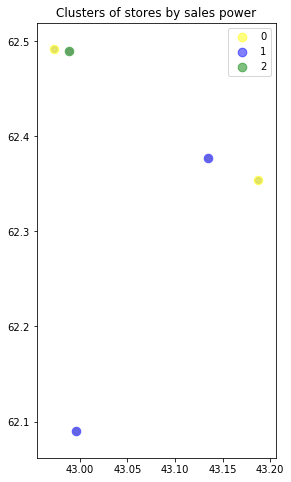

In [56]:
fig, ax = plt.subplots(figsize = (8,8))
store_Data_gr.plot(color='grey', ax=ax, alpha = 0.4)
store_Data_gr[store_Data_gr['Cluster']==0].geometry.plot(color = 'yellow', ax = ax, label = '0', alpha=.5, markersize = 75 )
store_Data_gr[store_Data_gr['Cluster']==1].geometry.plot(color = 'blue', ax = ax, label = '1', alpha=.5, markersize = 75 )
store_Data_gr[store_Data_gr['Cluster']==2].geometry.plot(color = 'green', ax = ax, label = '2', alpha=.5, markersize = 75 )
store_Data_gr[store_Data_gr['Cluster']==3].geometry.plot(color = 'red', ax = ax, label = '3', alpha=.5, markersize = 75 )

plt.title('Clusters of stores by sales'' power')
plt.legend();

Если же мы хотим разбить на 9 кластеров:

In [57]:
from sklearn.cluster import AgglomerativeClustering
# Another split on 9 smaller clusters
cluster = AgglomerativeClustering(n_clusters=9, affinity='euclidean', linkage='ward')
cluster.fit_predict(data)
pd.DataFrame(list(zip(df['Store'].values,cluster.labels_)),columns=['Store','Cluster']).head()

,Store,Cluster
0,1,0
1,2,3
2,3,0
3,4,1
4,5,4
